# Before You Start

The current set of notebooks are under constant development.

## Update Tutorial Repository

If you have previously cloned the tutorial repository, you may need to get the latest versions of the notebooks.

First check the status of your repository:
```
cd hls4ml-tutorial
git status 
```

You may have some _modified_ notebooks. For example:

```
# On branch csee-e6868-spring2021
# Changes not staged for commit:
#   (use "git add <file>..." to update what will be committed)
#   (use "git checkout -- <file>..." to discard changes in working directory)
#
#	modified:   part1_getting_started.ipynb
#	modified:   part2_advanced_config.ipynb
#	modified:   part2b_advanced_config.ipynb
#
no changes added to commit (use "git add" and/or "git commit -a")
```

You can make a copy of those modified notebooks if you had significat changes, otherwise the easiest thing to do is to discard those changes.

**ATTENTION** You will loose your local changes!

```
git checkout *.ipynb
```

At this point, you can update you copy of the repository:
```
git pull
```


## Update Conda Environment

It is likely that you are running this notebook in the Conda environment `hls4ml-tutorial-cu`.

If you did not do that yet, you should update the `hls4ml` packages with the latest changes in the working branch.

```
conda activate hls4ml-tutorial-cu
pip uninstall hls4ml
pip install git+https://github.com/GiuseppeDiGuglielmo/hls4ml.git@gdg/cosmetics#egg=hls4ml[profiling]
```

You may need to restart the Jupyter notebook.

# Part 4: Quantization


## Setup

As we did in the previous notebooks, let's import the libraries, call the magic functions, and setup the environment variables.

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


## Fetch the jet tagging dataset from Open ML

The [jet tagging dataset](https://www.openml.org/d/42468) is publicly available on [OpenML](https://www.openml.org).

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Construct a model
This time we're going to use QKeras layers.

QKeras is **Quantized Keras** for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

See also [our paper](https://arxiv.org/abs/2006.10159) (co-authored with Google).

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation

# Note the Q-layers from the QKeras package
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We create a simple _multi-layer perceptron (MLP)_ model. An MLP consists of at least three dense layers of nodes alternating with activation functions.

**EXACTLY AS BEFORE**

- We use the [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) that is essentially a stack of layers, where each layer has exactly one input tensor and one output tensor. See also the [Functional API](https://www.tensorflow.org/guide/keras/functional).
- We use _3_ hidden layers with _64_, then _32_, then _32_ neurons. See a plot of the model in the next few cell.
- Each layer will use ReLU activation.
- Add an output layer with _5_ neurons (one for each class), then finish with Softmax activation.
- [Initializers](https://keras.io/api/layers/initializers) define the way to set the initial random weights of Keras layers. In this case, we choose [LecunUniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/LecunUniform).
- [Regularizers](https://keras.io/api/layers/regularizers) help to get models that generalize to new, unseen data (see the [overfitting problem](https://en.wikipedia.org/wiki/Overfitting)); the regularizes allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes. In this case, we choose [L1 regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1) that producer _sparse models_, i.e. model where unnecessary features are set to zero, thus do not contribute to the model predictive power.

**WHAT'S NEW**

- We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`.
- We're also specifying `kernel_quantizer = quantized_bits(6,0,alpha=1)`. This will use 6-bit (of which 0 are integer and the sign bit is implicit) for the weights.
- We also use the same quantization for the biases, and `bias_quantizer=quantized_bits(6,0,alpha=1)` for 6-bit ReLU activations.
- `alpha=1` is scaling factor that we can ignore for the moment

In [4]:
model = Sequential()
model.add(QDense(64, input_shape=(16,), name='fc1',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(QDense(32, name='fc2',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(QDense(32, name='fc3',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(QDense(5, name='output',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train sparse

Let's train with model sparsity again, since QKeras layers are prunable.

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


## Train the model

We'll use the same settings as the model for [Part 1](part1_getting_started.ipynb): Adam optimizer with categorical crossentropy loss.

The callbacks will decay the learning rate and save the model into a directory `model_3`. The model isn't very complex, so this should just take a few minutes even on the CPU. If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_3')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_3/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_3/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.6368 - accuracy: 0.3262WARNING:tensorflow:From /home/giuseppe/miniconda3/envs/hls4ml-tutorial-cu/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
486/487 [============================>.] - ETA: 0s - loss: 1.3856 - accuracy: 0.4915
***callbacks***
saving losses to model_3/losses.log

Epoch 00001: val_loss improved from inf to 1.19395, saving model to model_3/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.19395, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_3/KERAS_check_model_last.h5

Epoch 00001: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 5s 10ms/step - loss: 1.3854 - accura

Epoch 13/30
486/487 [============================>.] - ETA: 0s - loss: 0.8277 - accuracy: 0.7306
***callbacks***
saving losses to model_3/losses.log

Epoch 00013: val_loss improved from 0.83666 to 0.82493, saving model to model_3/KERAS_check_best_model.h5

Epoch 00013: val_loss improved from 0.83666 to 0.82493, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 00013: saving model to model_3/KERAS_check_model_last.h5

Epoch 00013: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 5s 10ms/step - loss: 0.8277 - accuracy: 0.7307 - val_loss: 0.8249 - val_accuracy: 0.7308
Epoch 14/30
485/487 [============================>.] - ETA: 0s - loss: 0.8162 - accuracy: 0.7326
***callbacks***
saving losses to model_3/losses.log

Epoch 00014: val_loss improved from 0.82493 to 0.81425, saving model to model_3/KERAS_check_best_model.h5

Epoch 00014: val_loss improved from 0.82493 to 0.81425, saving model to model_3/KE

Epoch 26/30
481/487 [============================>.] - ETA: 0s - loss: 0.7572 - accuracy: 0.7463
***callbacks***
saving losses to model_3/losses.log

Epoch 00026: val_loss improved from 0.76259 to 0.76096, saving model to model_3/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 0.76259 to 0.76096, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 00026: saving model to model_3/KERAS_check_model_last.h5

Epoch 00026: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 8ms/step - loss: 0.7574 - accuracy: 0.7463 - val_loss: 0.7610 - val_accuracy: 0.7449
Epoch 27/30
483/487 [============================>.] - ETA: 0s - loss: 0.7553 - accuracy: 0.7468
***callbacks***
saving losses to model_3/losses.log

Epoch 00027: val_loss improved from 0.76096 to 0.75936, saving model to model_3/KERAS_check_best_model.h5

Epoch 00027: val_loss improved from 0.76096 to 0.75936, saving model to model_3/KER

## Check performance

How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model in [Part 1](part1_getting_started.ipynb)? 

Let's report the accuracy and make a ROC curve. The **quantized & pruned model** is shown with **solid lines**, the **unpruned model** from [Part 1](part1_getting_started.ipynb) is shown with **dashed lines**.

We should also check that hls4ml _can respect_ the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a **hls4ml model** configuration from this Quantized model, and plot its performance as the **dotted line**.

When the generated configuration is printed out, you'll notice that it uses 7 bits for the type, but we specified 6 !? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more bit.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers
- to _round_, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations.
- to _saturate_, rather than wrap around in case of overflows.

<img src="images/saturation_overflow.png" style="width:1024px;" />

Finally we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [13]:
import hls4ml
import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_3/hls4ml_prj',
                                                       #fpga_part='xczu7ev-ffvc1156-2-e') # ZCU106
                                                       fpga_part='xczu3eg-sbva484-1-e') # Ultra96
                                                       #fpga_part='xc7z020clg400-1') # Pynq-Z1
                                                       #fpga_part='xc7z007sclg225-1') # MiniZed
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  fc1_input
    Precision
      result:        ap_fixed<16,6>
  fc1
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1
  relu1
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  fc2
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1
  relu2
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  fc3
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1
  relu3
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  output
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1
  softmax
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    exp_

-----------------------------------
Baseline accuracy:          0.7503072289156627
Pruned, quantized accuracy: 0.7457831325301205
hls4ml accuracy:            0.7458614457831325
-----------------------------------


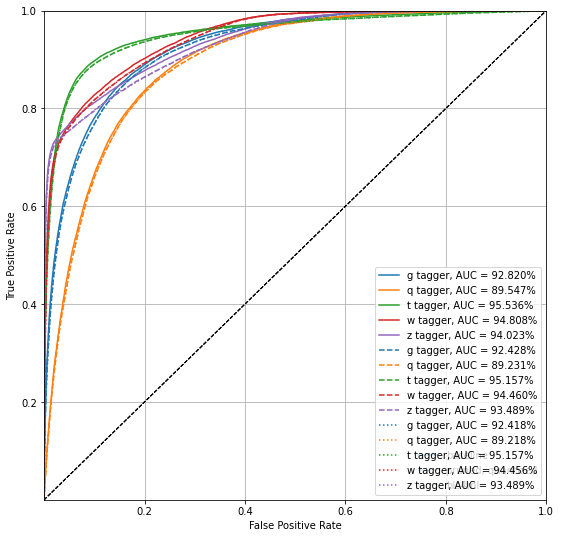

In [14]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print('-----------------------------------')
print("Baseline accuracy:          {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Pruned, quantized accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("hls4ml accuracy:            {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print('-----------------------------------')


# Enable logarithmic scale on TPR and FPR axes 
logscale_tpr = False # Y axis
logscale_fpr = False # X axis
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.plotMultiClassRoc(y_test, y_ref, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='-')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_qkeras, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_hls, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle=':')


from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
_ = ax.add_artist(leg)

# Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj/vivado_hls.log`

In [15]:
hls_results = hls_model.build(csim=False)

# print('-----------------------------------')
# #print(hls_results) # Print hashmap
# print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
# print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
# print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
# print("BRAM_18K:               {} (Aval. {})".format(hls_results['BRAM_18K'], hls_results['AvailableBRAM_18K']))
# print("DSP48E:                 {} (Aval. {})".format(hls_results['DSP48E'], hls_results['AvailableDSP48E']))
# print("FF:                     {} (Aval. {})".format(hls_results['FF'], hls_results['AvailableFF']))
# print("LUT:                    {} (Aval. {})".format(hls_results['LUT'], hls_results['AvailableLUT']))
# print("URAM:                   {} (Aval. {})".format(hls_results['URAM'], hls_results['AvailableURAM']))
# print('-----------------------------------')

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [16]:
hls4ml.report.read_vivado_report('model_3/hls4ml_prj')

Found 1 solution(s) in model_3/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Feb 24 17:47:20 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.332 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+-------

Print the report for the model trained in [Part 1](part1_getting_started.ipynb). Now, compared to the model from [Part 1](part1_getting_started.ipynb), this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from Part 1**

In [17]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Feb 24 16:46:21 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.198 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+-------

Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vivado HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [18]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj')

Found 1 solution(s) in model_2/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Feb 24 17:13:14 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.332 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+-------

## N.B. Vivado HLS Overstimates Resources 

Note as well that the Vivado HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.

## To Conclude

After these lectures you have
- gained some hands on experience with hls4ml: you translated a NN to FPGA firmware, run simulation and synthesis;
- tuned NN inference performance withe precision and reuse factor;
- learned how to simply prune a NN and see the impact on resources;
- trained a model with small numbers of bits using QKeras and see the impact on resources.

This is just an introduction to the tool and we [welcome](https://fastmachinelearning.org) people joining the open-source project.